# COVID-19 - How long until herd immunity?
> Everyone would like to know when this pandemic will end. Herd immunity is a possible scenario in which the pandemic ends by immunizing the population if we don't find a vaccine. But how long do we have to wait until we're there?

- comments: true
- author: Caglar Cakan
- categories: [covid19]
- permalink: /covid-herd-immunity/
- image: images/icon_herd_immunity.png
- license: Creative Commons

In [1]:

#hide_input
import datetime
print("This page was last built on", datetime.datetime.now().strftime("%d.%m.%y %H:%M:%S"))

This page was last built on 17.05.20 12:53:01


There seems to be only two realistic scenarios how the Corona pandemic could end. 

In the first scenario, we find a vaccine and reach wide-spread immunity on a global scale. This could take one year or maybe two. Looking at the second option, this could be the better strategy:

In the second scenario, we reach herd immunity and most of the population produces antibodies for the Corona virus. The threshold for herd immunity for the Corona virus is assumed to be around 60% of the global population.

**Disclaimer:** Please note that "confirmed cases" are known to grossly underestimate the number of people with antibodies. [Recent numbers](https://www.cnbc.com/2020/04/23/new-york-antibody-study-estimates-13point9percent-of-residents-have-had-the-coronavirus-cuomo-says.html) (23.04.2020) suggested that up to 13.9% of NYC citizens could have antibodies although the number of confirmed cases is at around 5% of the population. In this notebook, we also plot the results for when 50% or 90% of cases remain undetected.

In [2]:
# %load ../../load_magic/pip_install.txt

import sys

command_str = '{sys.executable} -m pip install --upgrade countryinfo'.format(sys=sys)
print(command_str)
!{command_str}

C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade countryinfo
  Created wheel for countryinfo: filename=countryinfo-0.1.0-py3-none-any.whl size=592045 sha256=62acd0ca114c1f03b6128d059bd685bfb40d2035fa7861f5fa9faebc60e1cba4
  Stored in directory: c:\users\577342\appdata\local\pip\cache\wheels\fd\3a\dd\d57a9e691c7e2f1015fe85d1a61616fc0820517432caf08c34
Successfully built countryinfo


In [53]:

#hide
import numpy as np

import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

import requests
import io

from countryinfo import CountryInfo

In [54]:

#hide
import matplotlib

matplotlib.rc_file('../data/mplstyles/dark.mplstyle')

In [51]:
# %load ../../load_magic/py_path.txt

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [52]:

#hide
import lib.covid_data as cd

In [4]:

%pprint

Pretty printing has been turned OFF


In [5]:

from datetime import date, timedelta

date.today() + timedelta(days=int((0.6*10_230_000-600_000)/466))

datetime.date(2052, 11, 30)

In [24]:

import pandas as pd

name = 'deaths'
base_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'
url = f'{base_url}/time_series_covid19_{name}_global.csv'
columns_list = ['Country/Region', 'Province/State', 'Lat', 'Long']
df = pd.read_csv(url, index_col=columns_list)
df['type'] = name.lower()
df.columns.name = 'date'
df = df.set_index('type', append=True).reset_index(['Lat', 'Long'], drop=True).stack().reset_index().set_index('date')
df.index = pd.to_datetime(df.index)
df.columns = ['country', 'state', 'type', 'cases']
df.sample(5)

,country,state,type,cases
date,,,,
2020-03-13,North Macedonia,NaN,deaths,0
2020-03-01,Somalia,NaN,deaths,0
2020-03-04,Cambodia,NaN,deaths,0
2020-03-07,China,Shandong,deaths,6
2020-01-25,Mozambique,NaN,deaths,0


In [41]:

import pandas as pd

BASE_URL = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'
NONDATE_COLUMNS_LIST = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region',
                        'Lat', 'Long_', 'Combined_Key', 'Population']
DROPPED_COLUMNS_LIST = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Lat', 'Long_', 'Combined_Key',
                        'Population']
TIMESERIES_COLUMNS_LIST = ['state', 'country', 'type', 'cases']
name = 'confirmed'
url = f'{BASE_URL}/time_series_covid19_{name}_US.csv'
#print(pd.read_csv(url).columns.tolist())
df = pd.read_csv(url, index_col=NONDATE_COLUMNS_LIST[:-1])
df['type'] = name.lower()
df.columns.name = 'date'
df = df.set_index('type', append=True).reset_index(DROPPED_COLUMNS_LIST[:-1], drop=True).stack().reset_index().set_index('date')
df.index = pd.to_datetime(df.index)
df.columns = TIMESERIES_COLUMNS_LIST
df = df.groupby(['date', 'state', 'type']).sum().reset_index().sort_values(['state', 'date']).set_index('date')
df.sample(5)

,state,type,cases
date,,,
2020-03-18,Massachusetts,confirmed,252
2020-04-29,Nebraska,confirmed,3851
2020-01-25,Grand Princess,confirmed,0
2020-04-23,Virginia,confirmed,10998
2020-05-05,Massachusetts,confirmed,70271


In [42]:

import pandas as pd

BASE_URL = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series'
NONDATE_COLUMNS_LIST = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region',
                        'Lat', 'Long_', 'Combined_Key', 'Population']
DROPPED_COLUMNS_LIST = ['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Lat', 'Long_', 'Combined_Key',
                        'Population']
TIMESERIES_COLUMNS_LIST = ['state', 'country', 'type', 'cases']
def load_timeseries(name, base_url=BASE_URL):
    url = f'{base_url}/time_series_covid19_{name}_US.csv'
    if name == 'confirmed':
        columns_list = NONDATE_COLUMNS_LIST[:-1]
    else:
        columns_list = NONDATE_COLUMNS_LIST
    df = pd.read_csv(url, index_col=columns_list)
    df['type'] = name.lower()
    df.columns.name = 'date'
    if name == 'confirmed':
        columns_list = DROPPED_COLUMNS_LIST[:-1]
    else:
        columns_list = DROPPED_COLUMNS_LIST
    df = df.set_index('type', append=True).reset_index(columns_list, drop=True).stack().reset_index().set_index('date')
    df.index = pd.to_datetime(df.index)
    df.columns = TIMESERIES_COLUMNS_LIST
    df = df.groupby(['date', 'state', 'type']).sum().reset_index().sort_values(['state', 'date']).set_index('date')
    
    return df

In [43]:

#hide

def get_countries_with_min_cases_for_df(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)
           ].sort_values(by=by, ascending=False)
    countries = countries['state'].values
    return countries

def get_countries_with_min_cases(df_cases, by='cases', min_cases = 10):
    MIN_CASES = min_cases
    countries = df_cases[df_cases[by].ge(MIN_CASES)].sort_values(by=by, ascending=False)
    countries = countries['state'].unique()
    return countries

def filter_cases(df_cases, by='cases', min_cases = 10, since_cases=None):
    countries = get_countries_with_min_cases_for_df(df_cases, by, min_cases)
    if since_cases is None:
        SINCE_CASES_NUM = 100
    else:
        SINCE_CASES_NUM = since_cases
        
    COL_X = f'Days since case {SINCE_CASES_NUM}'
    dff2 = df_cases[df_cases['state'].isin(countries)].copy()
    dff2['date'] = dff2.index
    days_since = (dff2.assign(F=dff2[by].ge(SINCE_CASES_NUM))
                  .set_index('date')
                  .groupby('state')['F'].transform('idxmax'))
    dff2[COL_X] = (dff2['date'] - days_since.values).dt.days.values
    dff2 = dff2[dff2[COL_X].ge(0)]
    return dff2

In [44]:

#hide
df_deaths = load_timeseries('deaths')
df_confirmed = load_timeseries('confirmed')

# concatenate both timeseries
df_cases = pd.concat((df_confirmed, df_deaths), axis=1)
df_cases.columns = ['state', 'type', 'confirmed', 'state', 'type', 'deaths']
df_cases = df_cases.loc[:,~df_cases.columns.duplicated()]

In [45]:

#hide
# create diffs
df_cases['new_deaths'] = df_cases.deaths.diff()
# flatten artifacts from one country to the next
df_cases.loc[df_cases['new_deaths']<0, 'new_deaths'] = 0
df_cases['new_confirmed'] = df_cases.confirmed.diff()
df_cases.loc[df_cases['new_confirmed']<0, 'new_confirmed'] = 0

In [58]:

#hide
MIN_CASES = 1000
SINCE_CASES = 50
dff2 = filter_cases(df_cases, 'confirmed', MIN_CASES, SINCE_CASES)

In [64]:

#hide_input
countries = list(get_countries_with_min_cases(dff2, 'deaths', min_cases=100))
countries.sort()

In [74]:

%run ../../load_magic/storage.py
s = Storage()
states_stats_df = s.load_object('states_stats_df')
print([cn for cn in states_stats_df.columns.tolist() if ('popu' in cn.lower()) or ('cens' in cn.lower())])
population_dict = states_stats_df.Census_Population_2010.to_dict()

['State_Population', 'Census_Estimate_2019', 'Census_Population_2010', 'Population_Per_Electoral_Vote_2019', 'Population_Per_House_Seat_2019', 'Population_Per_House_Seat_2010', 'Census_Bureau_Region_Number', 'Census_Bureau_Region_Name', 'Census_Bureau_Division_Number', 'Census_Bureau_Division_Name']


In [75]:

#hide
# ignore = ['China']

# countries = get_countries_with_min_cases(dff2, 'deaths', MIN_DEATHS)[:]
# countries = [c for c in countries if c not in ignore]
populations = {}

infected_population_list = []
deceased_population_list = []

days_until_full_infection_list = []
new_cases_mean_list = []

remove_countries = []
for str_country in countries:
    #print(f'{str_country}')
    country_info_str = str_country
        
    try:
        population = population_dict[country_info_str]
    except:
        # country population could not be received, skip
        print(f'Could not retrieve population size of {str_country}, skipping')
        remove_countries.append(str_country)
        #countries.remove(str_country)
        continue
    populations[str_country] = population

In [100]:

rows_list = []
HERD_IMMUNITY_THRESHOLD = 0.6
for str_country in populations.keys():
    df_cases_country = dff2[dff2['state']==str_country]
    population = populations[str_country]
    for date, row_series in df_cases_country.iterrows():
        new_cases = row_series.new_confirmed
        infected_population = row_series.confirmed
        if new_cases == 0:
            days_until_full_infection = np.nan
        else:
            days_until_full_infection = int((HERD_IMMUNITY_THRESHOLD * population - infected_population)/new_cases)
        row_dict = {}
        row_dict['date'] = date
        row_dict['state'] = str_country
        row_dict['days_until_full_infection'] = days_until_full_infection
        rows_list.append(row_dict.copy())
days_until_full_infection_df = pd.DataFrame(rows_list)
s.store_objects(days_until_full_infection=days_until_full_infection)

Pickling to D:\Documents\Repositories\notebooks\covid19\saves\pickle\days_until_full_infection.pickle


In [97]:

df_cases_country

,state,type,confirmed,deaths,new_deaths,new_confirmed,date,Days since case 50
date,,,,,,,,
2020-03-18,Alabama,confirmed,51,0,0.0,12.0,2020-03-18,0
2020-03-19,Alabama,confirmed,78,0,0.0,27.0,2020-03-19,1
2020-03-20,Alabama,confirmed,106,0,0.0,28.0,2020-03-20,2
2020-03-21,Alabama,confirmed,131,0,0.0,25.0,2020-03-21,3
2020-03-22,Alabama,confirmed,157,0,0.0,26.0,2020-03-22,4
2020-03-23,Alabama,confirmed,196,0,0.0,39.0,2020-03-23,5
2020-03-24,Alabama,confirmed,242,0,0.0,46.0,2020-03-24,6
2020-03-25,Alabama,confirmed,381,1,1.0,139.0,2020-03-25,7
2020-03-26,Alabama,confirmed,517,1,0.0,136.0,2020-03-26,8


In [76]:

for r in remove_countries:
    if r in countries:
        countries.remove(r)

for str_country in populations.keys():
    df_cases_country = dff2[dff2['state']==str_country]
    population = populations[str_country]
    
    # last reported cases
    last_new_cases = df_cases_country.new_confirmed[-1]
    
    # mean over 30 days    
    MEAN_CASES_DAYS = 30
    new_cases_mean = np.mean(df_cases_country.new_confirmed[-MEAN_CASES_DAYS:])
    new_cases_mean_list.append(new_cases_mean)
    
    # mean over 30 days    
    HERD_IMMUNITY_THRESHOLD = 0.6
    days_until_full_infection = int(population/new_cases_mean * HERD_IMMUNITY_THRESHOLD)
    days_until_full_infection_list.append(days_until_full_infection)
    
    # proportion of infected population
    
    infected_population = df_cases_country.confirmed[-1] / population * 100
    infected_population_list.append(infected_population)
    
    deceased_population = df_cases_country.deaths[-1] / population * 100
    deceased_population_list.append(deceased_population)
    
    f_str = '{}: {}% - cases: {:,} ({:,} days necessary to infect {}% of the population of {:,} at an infection rate of {:,} cases/day)'
    print(f_str.format(str_country, round(infected_population, 2), df_cases_country.confirmed[-1],
                       days_until_full_infection, int(HERD_IMMUNITY_THRESHOLD*100), population, int(new_cases_mean)))

Alabama: 0.24% - cases: 11,674 (11,739 days necessary to infect 60% of the population of 4,779,736 at an infection rate of 244 cases/day)
Arizona: 0.21% - cases: 13,666 (12,202 days necessary to infect 60% of the population of 6,392,017 at an infection rate of 314 cases/day)
California: 0.21% - cases: 78,725 (13,136 days necessary to infect 60% of the population of 37,253,956 at an infection rate of 1,701 cases/day)
Colorado: 0.43% - cases: 21,633 (6,782 days necessary to infect 60% of the population of 5,029,196 at an infection rate of 444 cases/day)
Connecticut: 1.03% - cases: 36,703 (3,090 days necessary to infect 60% of the population of 3,574,097 at an infection rate of 693 cases/day)
Delaware: 0.84% - cases: 7,547 (2,951 days necessary to infect 60% of the population of 897,934 at an infection rate of 182 cases/day)
Florida: 0.24% - cases: 44,811 (15,764 days necessary to infect 60% of the population of 18,801,310 at an infection rate of 715 cases/day)
Georgia: 0.38% - cases: 37,

# Infected population

To estimate how much the pandemic has progressed, we calculate the percentage of the population that was already infected. Since it is often assumed that many, if not most, of the cases in many countries are not detected, we also plot the number of estimated undetected cases, assuming that these are between 50% and 90% of the total cases, either because they remain asymptomatic or because they simply not tested for.

In [77]:

#hide
def hide_axis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    

In [78]:

images_dir = os.path.join(s.saves_folder, 'png', 'covid-herd-immunity')
os.makedirs(name=images_dir, exist_ok=True)

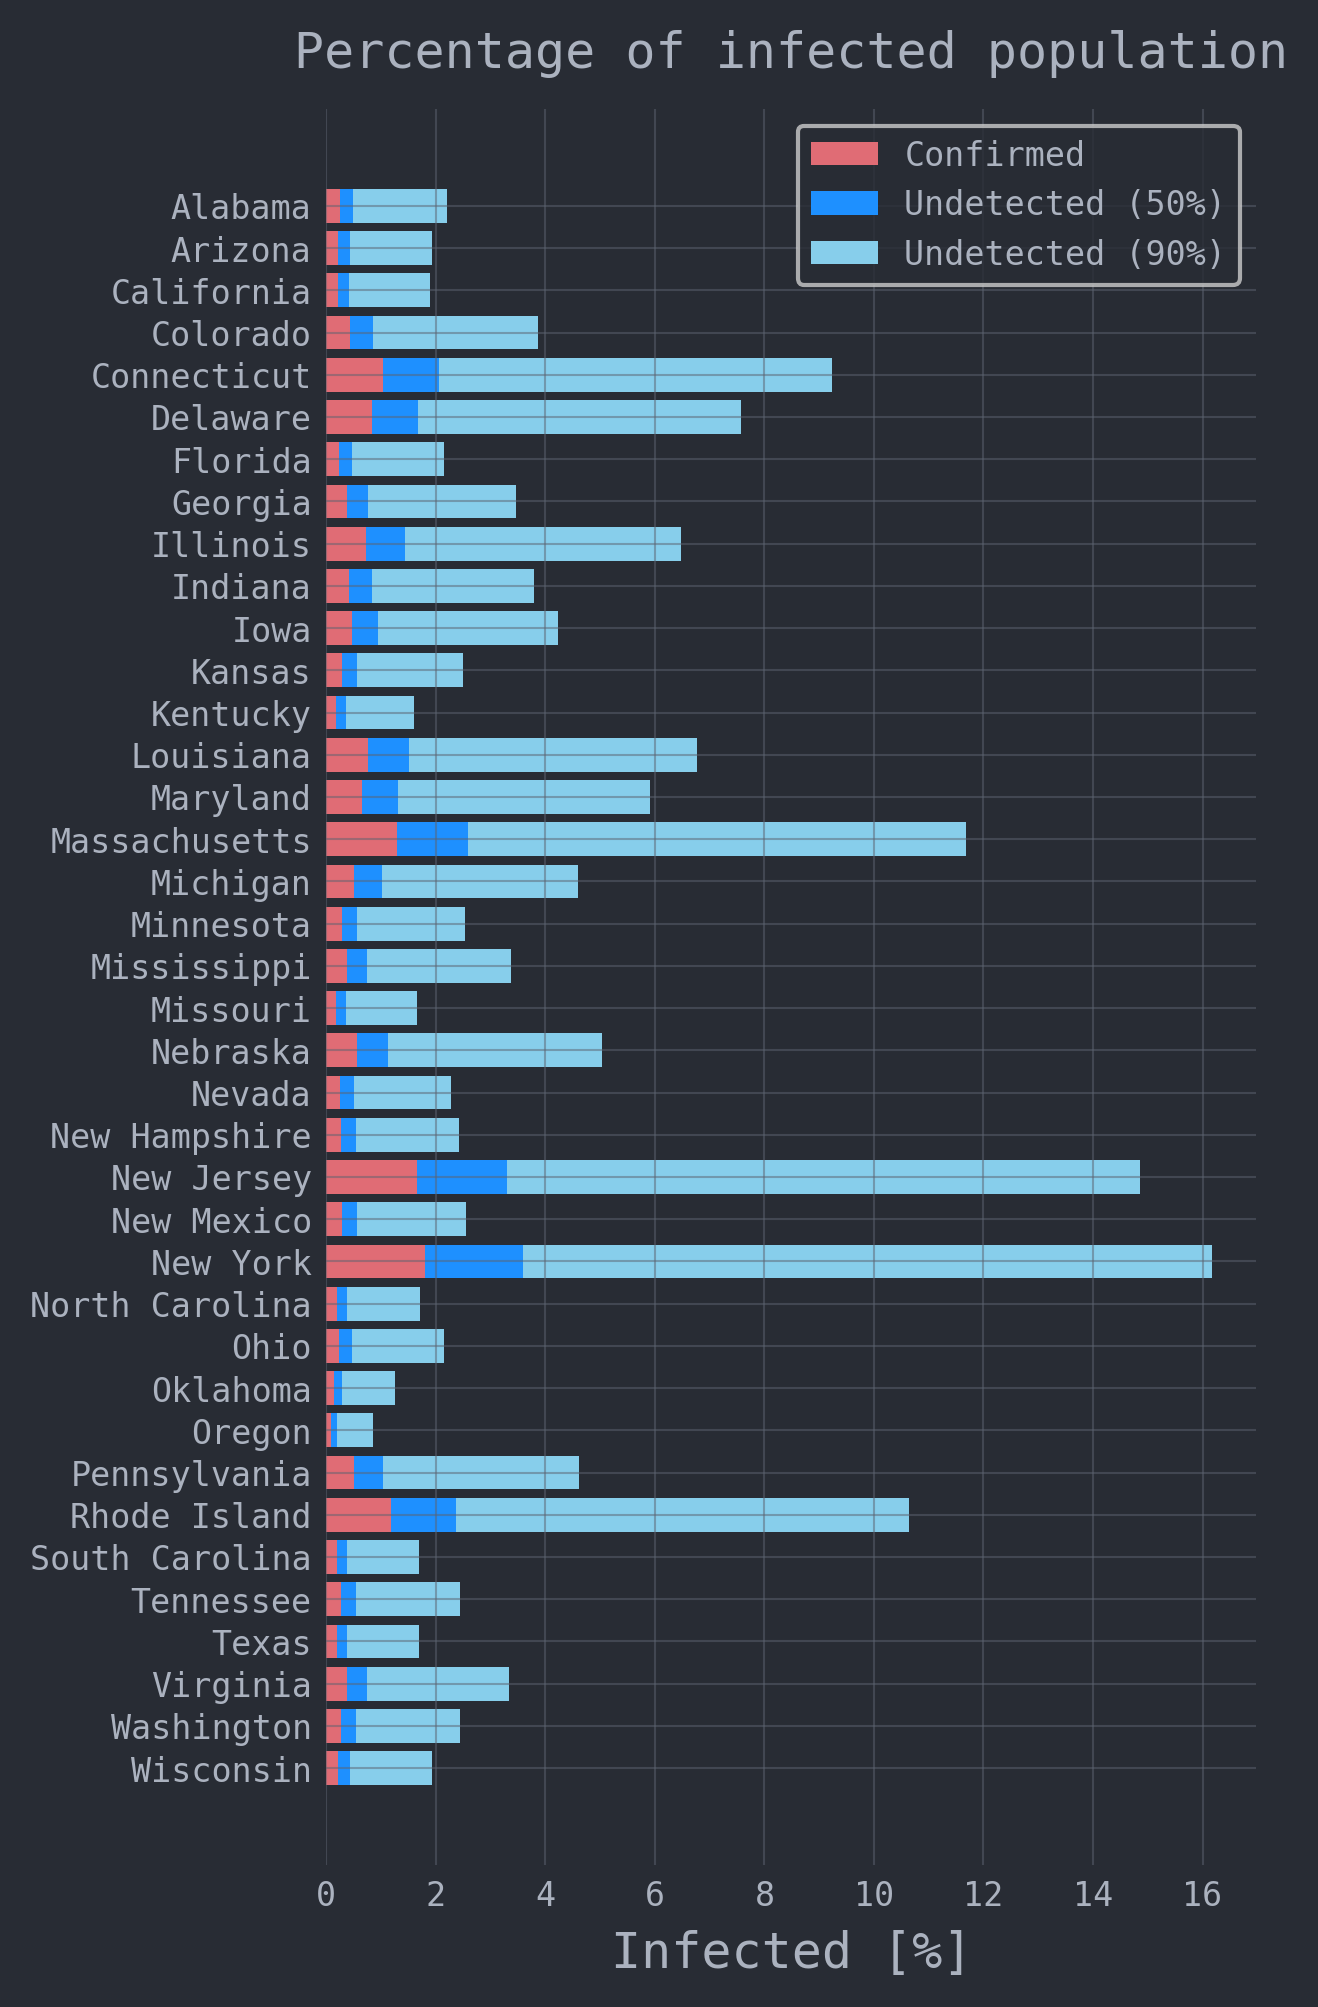

In [79]:

#hide_input
asymp = lambda factor: np.multiply(infected_population_list, factor)

height = len(countries)/5
fig, ax = plt.subplots(1, 1, figsize=(4, height), dpi=300)

# hack for disabling second plot 
axs = []
axs.append(ax)

# axs[1].barh(countries[::-1], deceased_population_list[::-1], color='gray', label='Deceased', alpha=0.8)
# axs[1].set_xlabel('Deceased [%]', fontsize=12)
# axs[1].tick_params(axis='both', which='major', labelsize=8)
# axs[1].set_yticklabels([])
# axs[1].yaxis.set_tick_params(width=1)


axs[0].barh(countries[::-1], infected_population_list[::-1], color='C0', label='Confirmed')
axs[0].barh(countries[::-1], asymp(2)[::-1], color='dodgerblue', label='Undetected (50%)', ls='--', lw=1,zorder=-2)
#axs[0].barh(countries[::-1], asymp(3)[::-1], left=infected_population_list[::-1], color='dodgerblue', label='Undetected (75%)',
#ls='--', alpha=0.6,lw=1)
axs[0].barh(countries[::-1], asymp(9)[::-1], color='skyblue', label='Undetected (90%)', ls='--', lw=1, zorder=-3)
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].yaxis.set_tick_params(width=1)


plt.title('Percentage of infected population', fontsize=12)
axs[0].set_xlabel('Infected [%]', fontsize=12)
max_value = np.max(asymp(3)[::-1]) + infected_population_list[::-1][np.argmax(asymp(3)[::-1])]
axs[0].legend(bbox_to_anchor=(1, 1.0), fontsize=8)
hide_axis(axs[0])

plt.savefig(os.path.join(images_dir, 'infected_percentage.png'), bbox_inches='tight')

# take a screenshot
import matplotlib
bob = matplotlib.transforms.Bbox([[-0.45, height-3.8], [3.75, height-.8]])
plt.grid(alpha=0.5, lw=0.5)
plt.savefig(os.path.join(s.saves_folder, 'png', 'icon_herd_immunity.png'), bbox_inches=bob, pad_inches=0.0)

# Extrapolation

We can estimate the time it takes to reach a 60% infection of the population by extrapolating the already observed cases into the future. This estimation is model-free: we simply take the *30 day average* of the past confirmed new cases and assume that the infection rate (or rather the case confirmation rate) stays constant. Then, we can easily calculate how long it would take for each country to reach 60% of its population. 

As of 25.04.2020, this number for many, if not all, countries is absurdly high. This can be due to do with the fact the outbreak hasn't really started in most places yet since only a tiny amount of the population was infected or that testing capabilities are still very insufficient in many places. This number will change as the pandemic progresses and as we get a better estimation of the actual infection rate.

In [89]:
countries

['Alabama', 'Arizona', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'Tennessee', 'Texas', 'Virginia', 'Washington', 'Wisconsin']

In [92]:

def show_years_until_plot(states_list, days_until_full_infection_list):
    years_until_full_infection_list = np.divide(days_until_full_infection_list, 365)

    height = len(states_list)/5
    fig, axs = plt.subplots(1, 1, figsize=(4, height), dpi=300)
    hide_axis(axs)


    plt.barh(states_list[::-1], years_until_full_infection_list[::-1], color='C0',  edgecolor='k', label='at 30-day mean infection rate')


    plt.barh(states_list[::-1], np.divide(years_until_full_infection_list[::-1], 3), color='dodgerblue', edgecolor='k',
             label='50% undetected infection rate')
    plt.barh(states_list[::-1], np.divide(years_until_full_infection_list[::-1], 9), color='skyblue', edgecolor='k',
             label='90% undetected infection rate')



    plt.tick_params(axis='both', which='major', labelsize=8)
    plt.title(f'Years until {int(HERD_IMMUNITY_THRESHOLD*100)}% of the\npopulation is infected', fontsize=12)
    plt.xlabel('Years', fontsize=12)

    x_thresh = np.median(years_until_full_infection_list)
    plt.xlim(0, x_thresh)

    for i, c in enumerate(states_list[::-1]):
        x_val = years_until_full_infection_list[::-1][i] 
        x_val *= 1.03
        if x_val > x_thresh:
            x_val = x_thresh*1.01
        text_str = f'{years_until_full_infection_list[::-1][i]:0.1f}y  ({int(new_cases_mean_list[::-1][i])} cases/d)'
        txt = plt.text(x_val, i-0.2, text_str, fontsize=6, fontweight='regular', color='C0')
    plt.grid(alpha=0.5, lw=0.5)
    plt.legend(bbox_to_anchor=(1.52,0.91), bbox_transform=plt.gcf().transFigure, fontsize=8)

    plt.savefig(os.path.join(images_dir, 'years_until.png'), bbox_inches='tight')

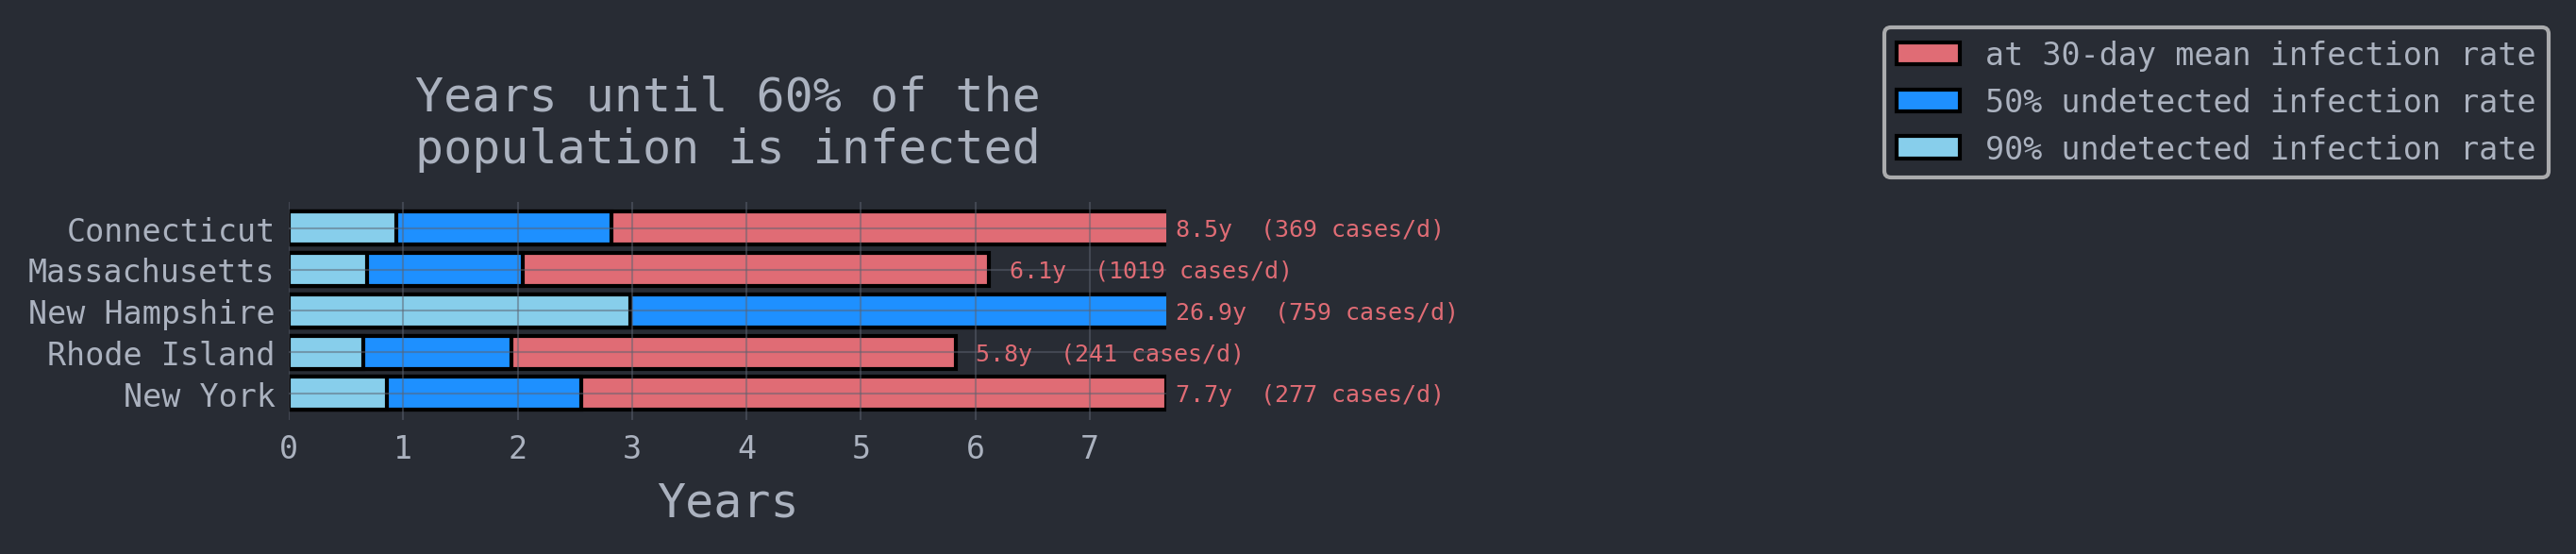

In [95]:

idx_list = []
for state_name in ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont', 'New York']:
    if state_name in countries:
        idx_list.append(countries.index(state_name))
show_years_until_plot(states_list=[countries[idx] for idx in idx_list],
                      days_until_full_infection_list=[days_until_full_infection_list[idx] for idx in idx_list])

## Combined view

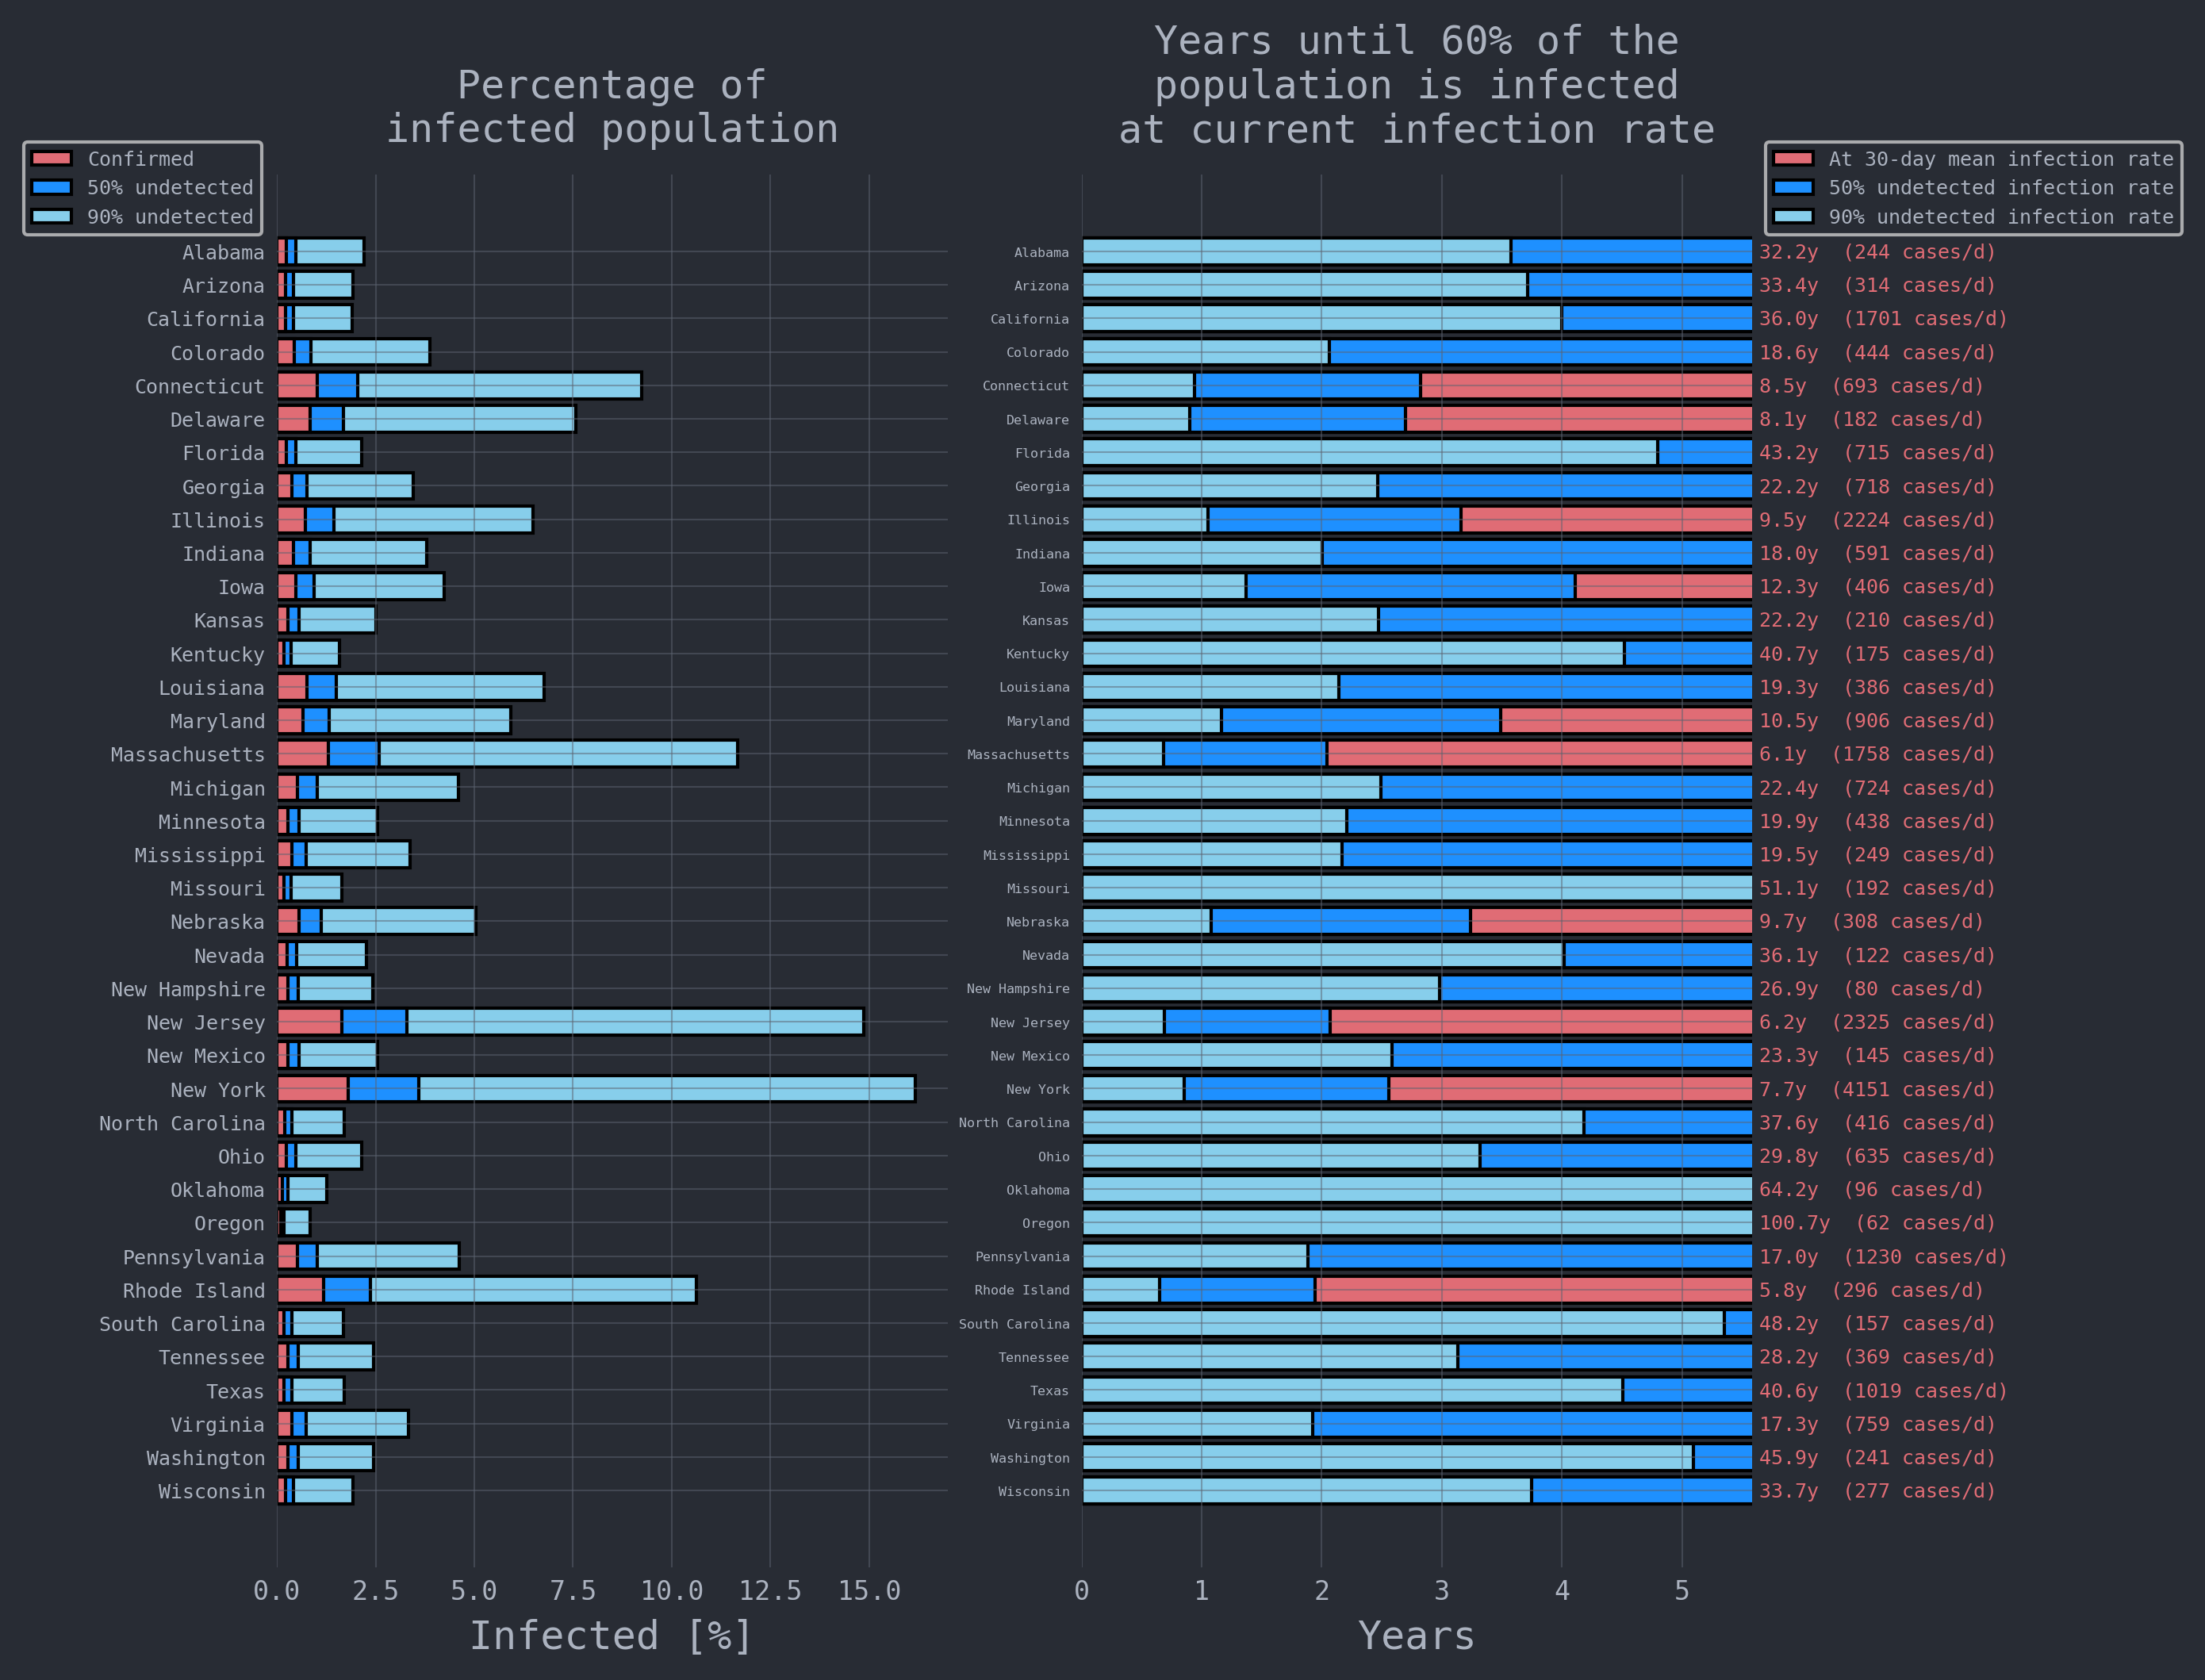

In [81]:

#hide_input
asymp = lambda factor: np.multiply(infected_population_list, factor)

height = len(countries)/5
fig, axs = plt.subplots(1, 2, figsize=(8, height), dpi=300)
axs[0].barh(countries[::-1], infected_population_list[::-1], color='C0', edgecolor='k',label='Confirmed')
axs[0].barh(countries[::-1], asymp(2)[::-1], color='dodgerblue', edgecolor='k',label='50% undetected', lw=1,zorder=-2)
#axs[0].barh(countries[::-1], asymp(3)[::-1], left=infected_population_list[::-1], color='dodgerblue', label='Undetected (75%)', ls='--',
#alpha=0.6,lw=1)
axs[0].barh(countries[::-1], asymp(9)[::-1], color='skyblue', edgecolor='k',label='90% undetected', lw=1, zorder=-3)

axs[0].tick_params(axis='y', which='major', labelsize=6)
axs[0].tick_params(axis='x', which='major', labelsize=8)
axs[0].yaxis.set_tick_params(width=1)


axs[0].set_title('Percentage of\ninfected population', fontsize=12)
axs[0].set_xlabel('Infected [%]', fontsize=12)
max_value = np.max(asymp(3)[::-1]) + infected_population_list[::-1][np.argmax(asymp(3)[::-1])]
#axs[0].legend(bbox_to_anchor=(1, 1.0), fontsize=8)
axs[0].legend(bbox_to_anchor=(-0.2,0.99), loc='center', bbox_transform=axs[0].transAxes, fontsize=6)


import matplotlib
bob = matplotlib.transforms.Bbox([[-0.7, height-3.8], [3.5, height-.8]])
axs[0].grid(alpha=0.5, lw=0.5)
#plt.savefig('../images/icon_herd_immunity.png', bbox_inches=bob, pad_inches=0.0)



years_until_full_infection_list = np.divide(days_until_full_infection_list, 365)
axs[1].barh(countries[::-1], years_until_full_infection_list[::-1], color='C0',  edgecolor='k', label='At 30-day mean infection rate')
axs[1].barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 3), color='dodgerblue', edgecolor='k',
            label='50% undetected infection rate')
plt.barh(countries[::-1], np.divide(years_until_full_infection_list[::-1], 9), color='skyblue', edgecolor='k',
         label='90% undetected infection rate')


axs[1].tick_params(axis='y', which='major', labelsize=4)
axs[1].tick_params(axis='x', which='major', labelsize=8)

axs[1].set_title(f'Years until {int(HERD_IMMUNITY_THRESHOLD*100)}% of the\npopulation is infected\nat current infection rate',
                 fontsize=12)
axs[1].set_xlabel('Years', fontsize=12)

x_thresh = np.median(years_until_full_infection_list) / 4
axs[1].set_xlim(0, x_thresh)

for i, c in enumerate(countries[::-1]):
    x_val = years_until_full_infection_list[::-1][i] 
    x_val *= 1.03
    if x_val > x_thresh:
        x_val = x_thresh*1.01
    # delete this line for dynamic spacing
    x_val = x_thresh*1.01
    txt = plt.text(x_val, i-0.2, f'{years_until_full_infection_list[::-1][i]:0.1f}y  ({int(new_cases_mean_list[::-1][i])} cases/d)',
                   fontsize=6, fontweight='regular', color='C0')
axs[1].grid(alpha=0.5, lw=0.5)
axs[1].legend(bbox_to_anchor=(1.33,0.99), loc='center', bbox_transform=axs[1].transAxes, fontsize=6)
hide_axis(axs[0])
hide_axis(axs[1])

plt.savefig(os.path.join(images_dir, 'combined.png'), bbox_inches='tight')

plt.show();

## Baseline measurements

Here we show the case rate for each country and highlight the last 30 days of confirmed cases that were used as a baseline to project the case rate into the future.

Alabama


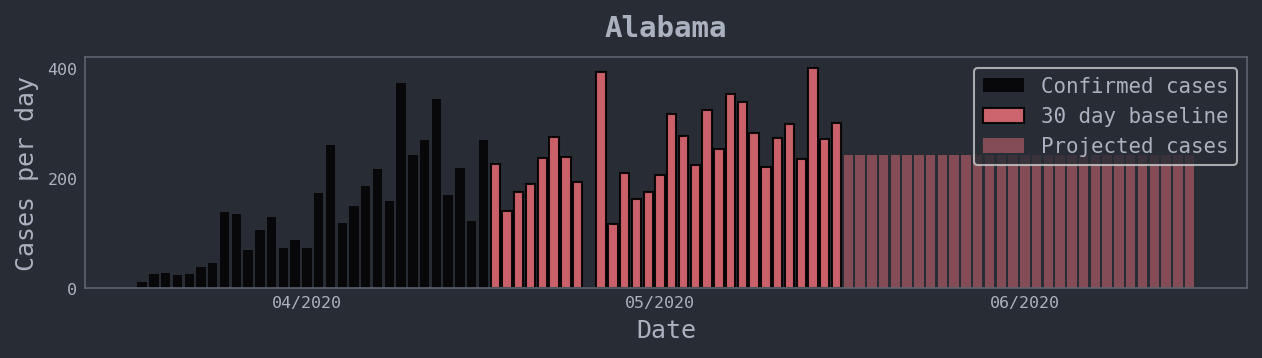

Arizona


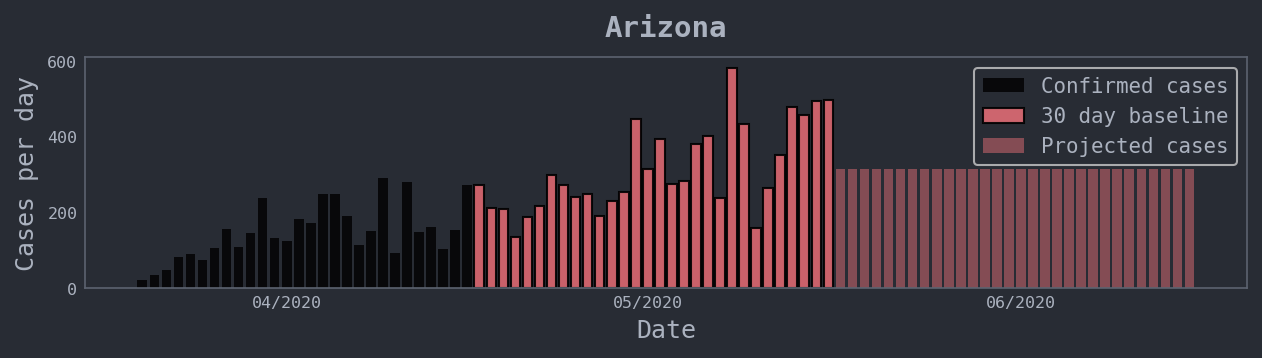

California


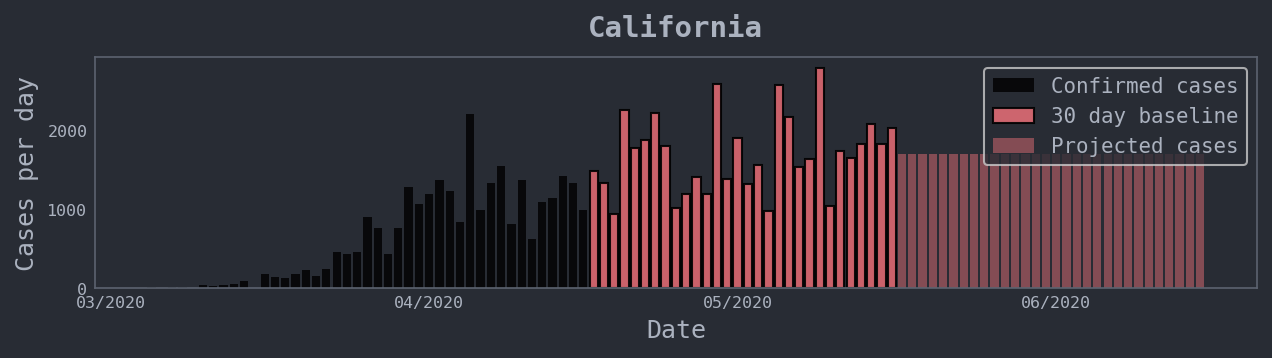

Colorado


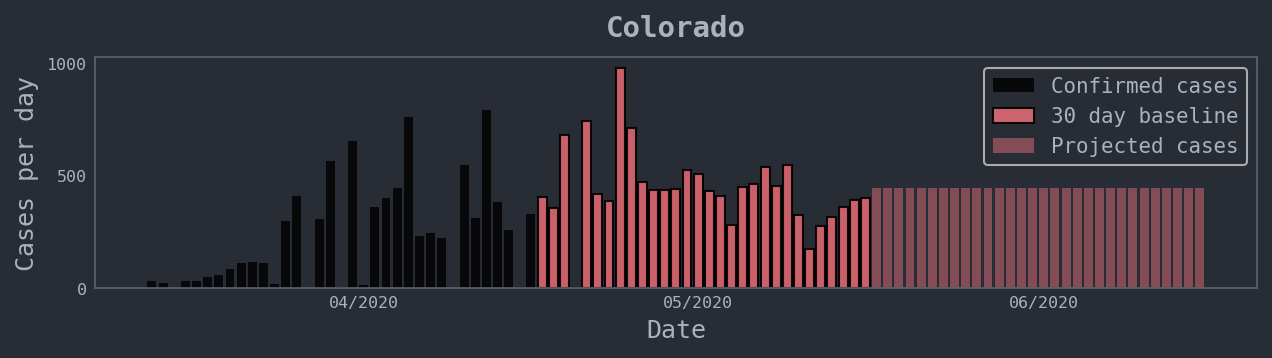

Connecticut


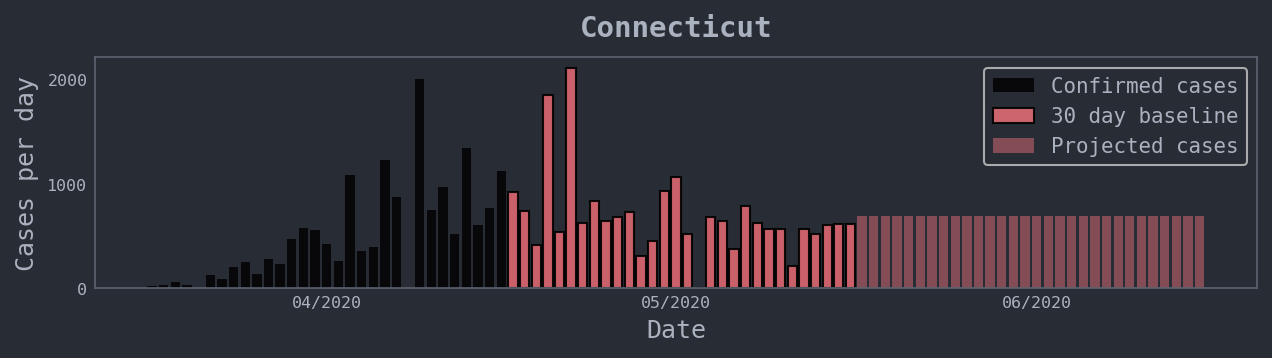

Delaware


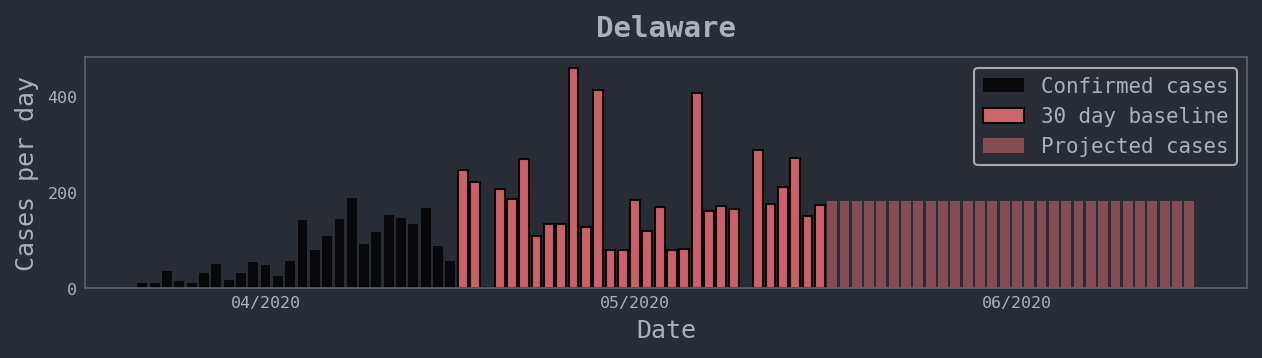

Florida


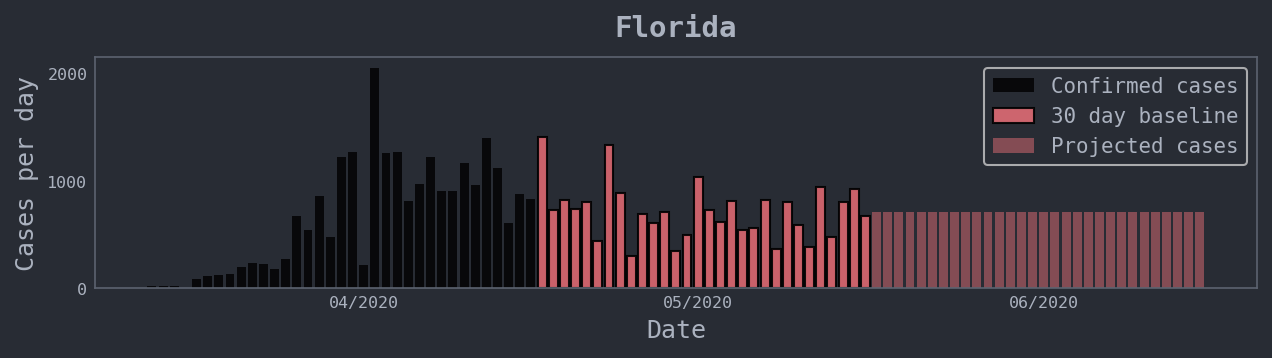

Georgia


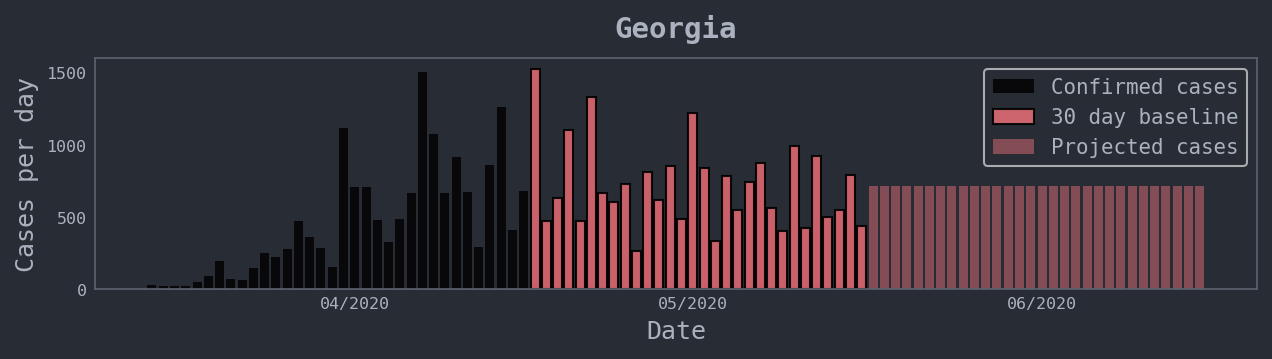

Illinois


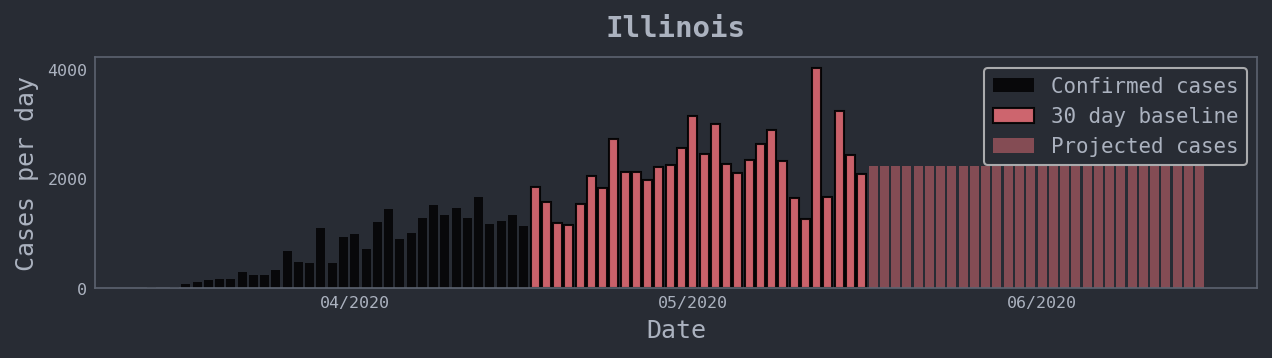

Indiana


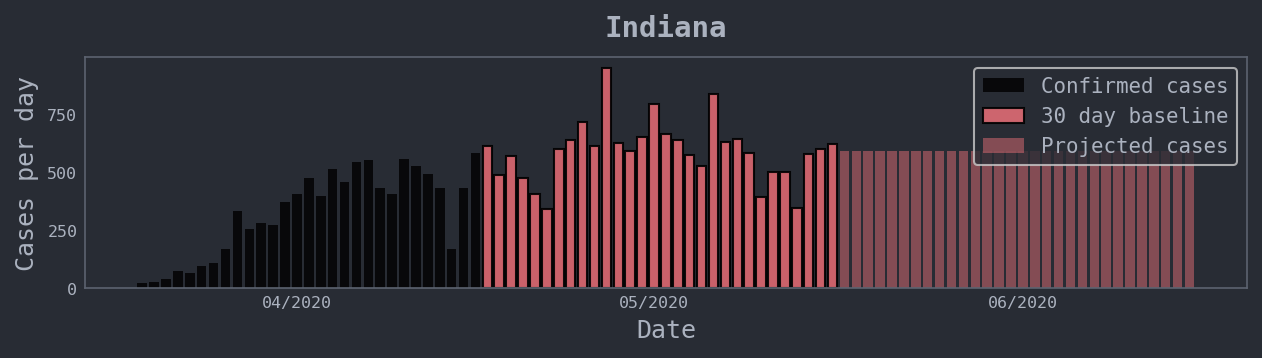

Iowa


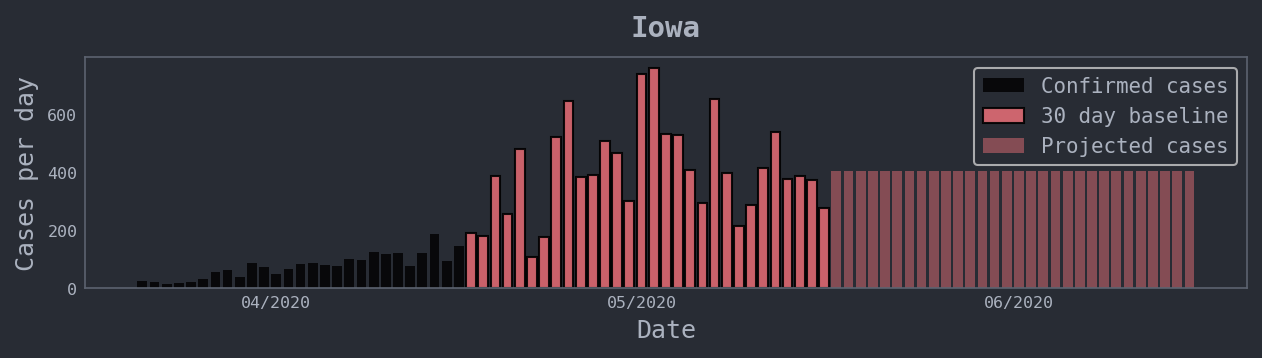

Kansas


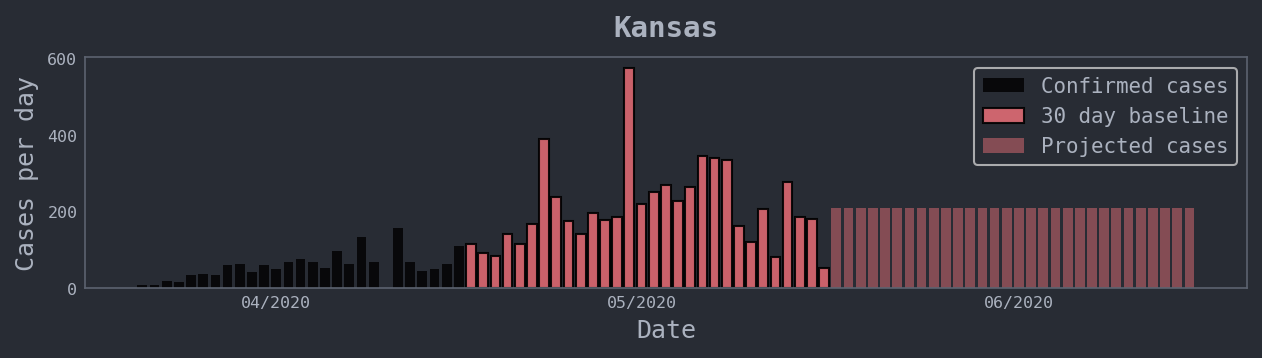

Kentucky


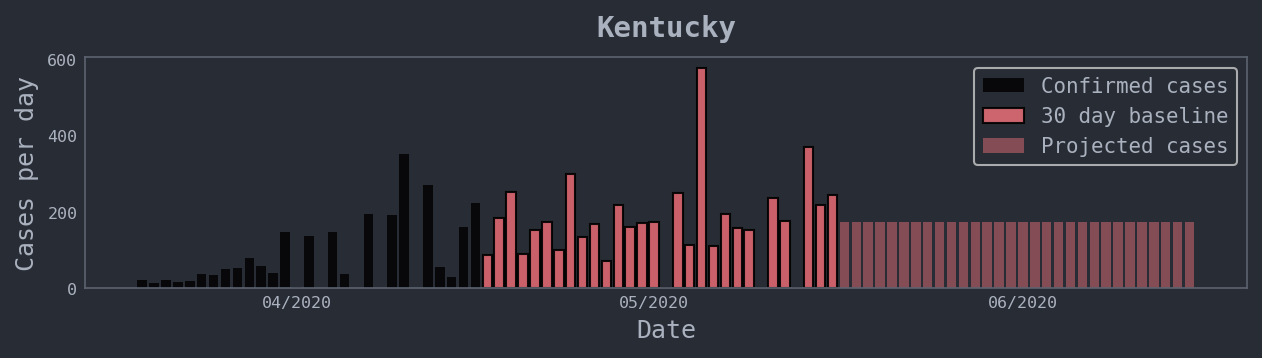

Louisiana


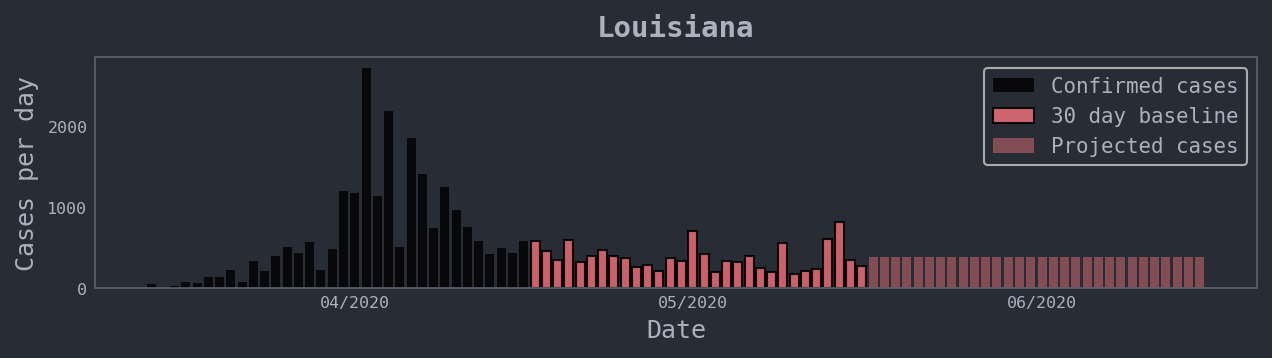

Maryland


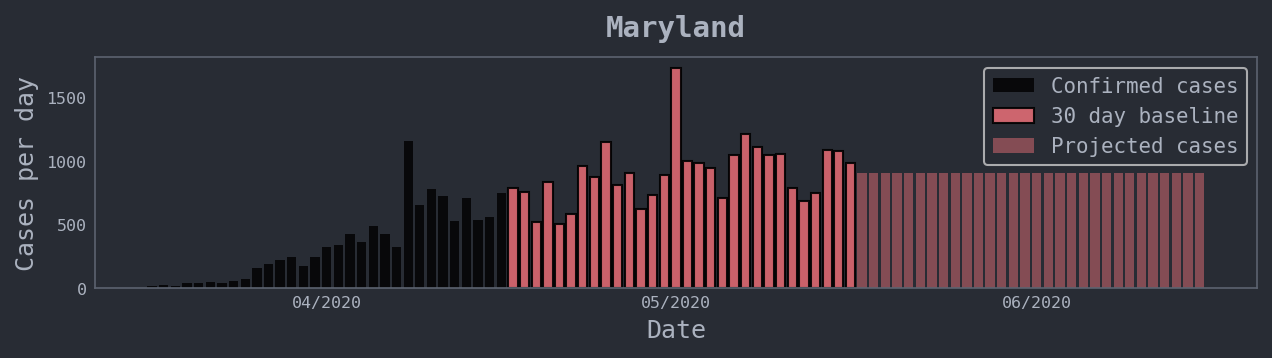

Massachusetts


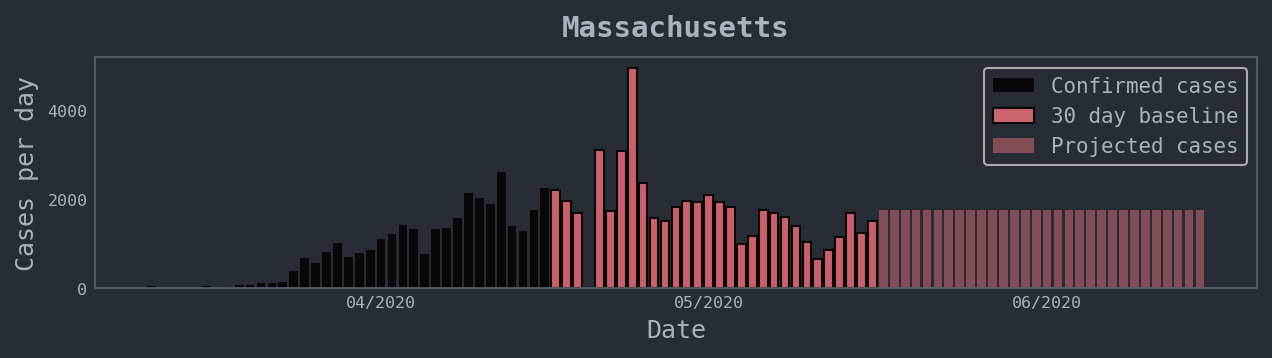

Michigan


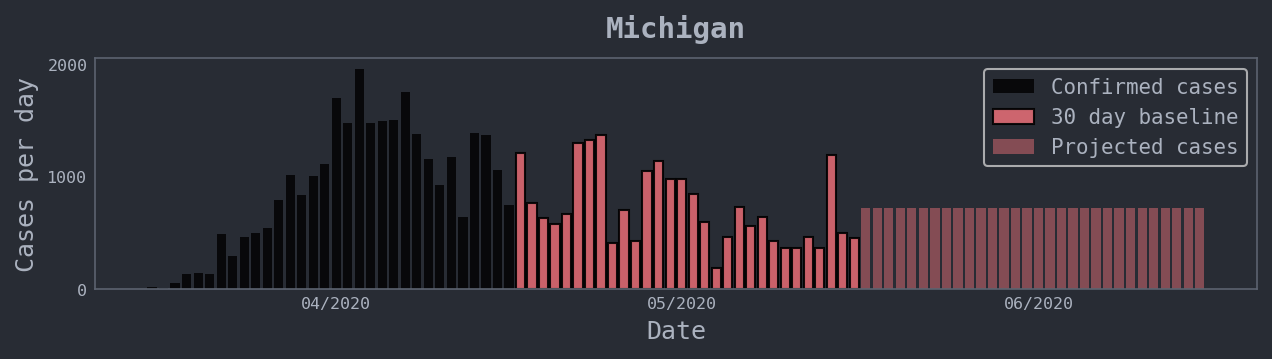

Minnesota


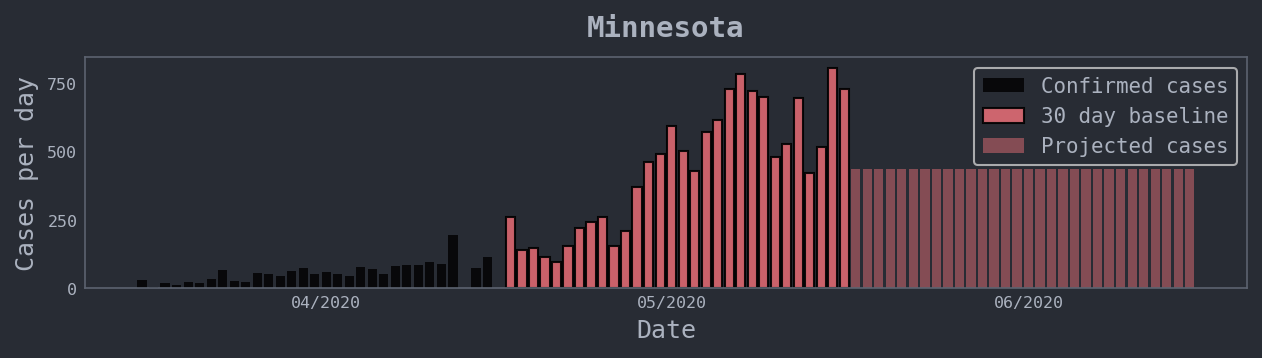

Mississippi


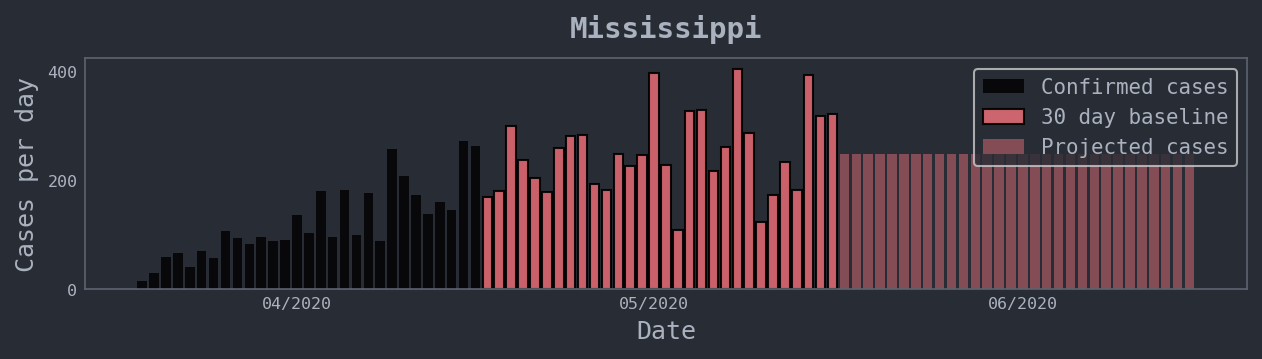

Missouri


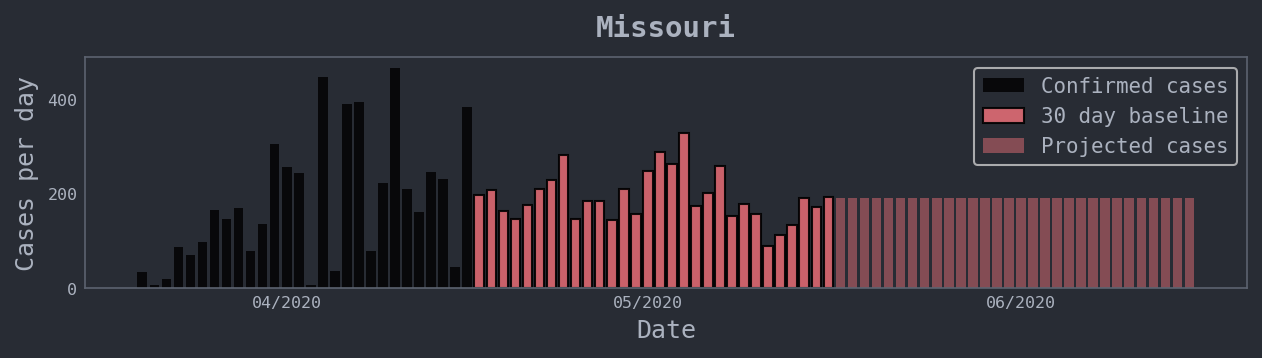

Nebraska


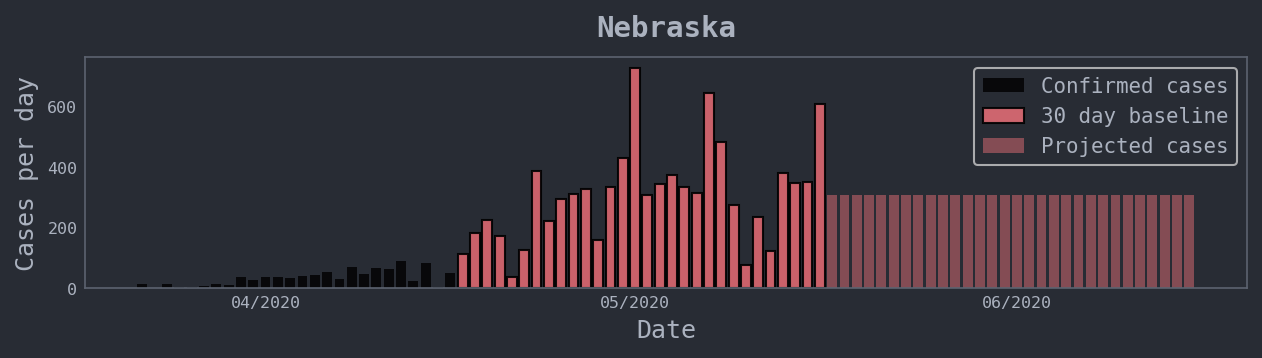

Nevada


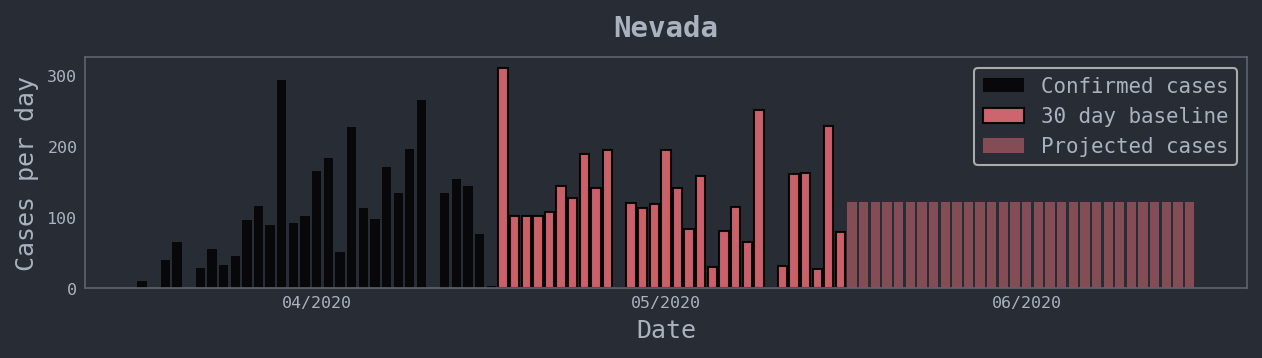

New Hampshire


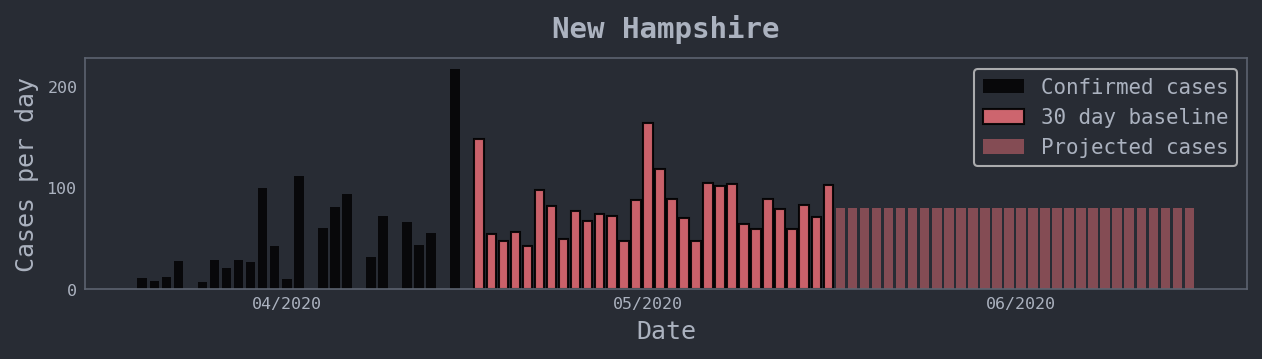

New Jersey


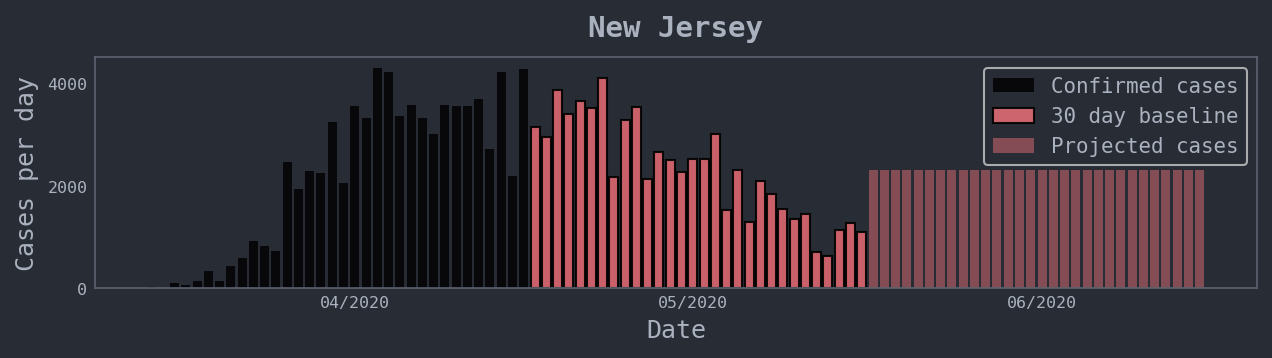

New Mexico


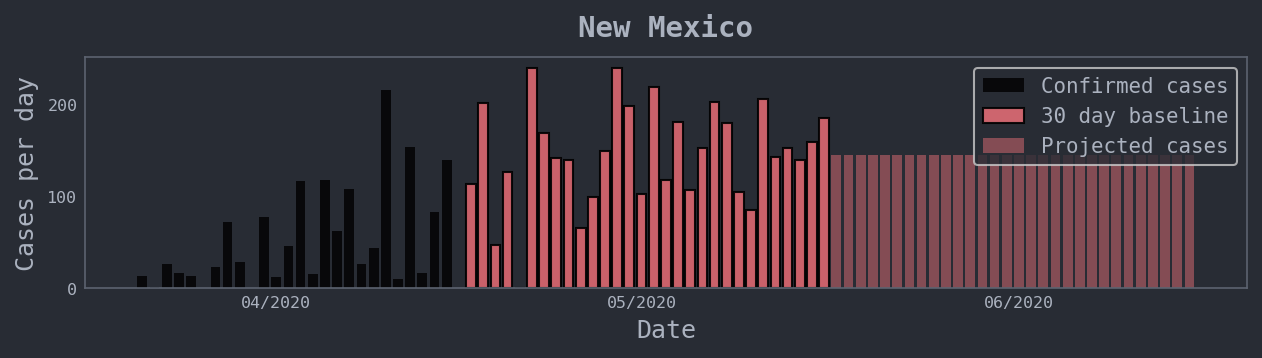

New York


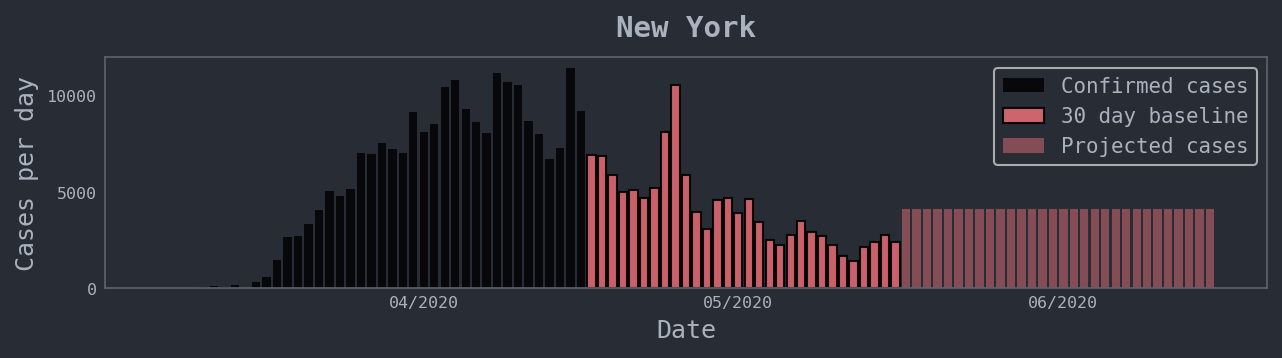

North Carolina


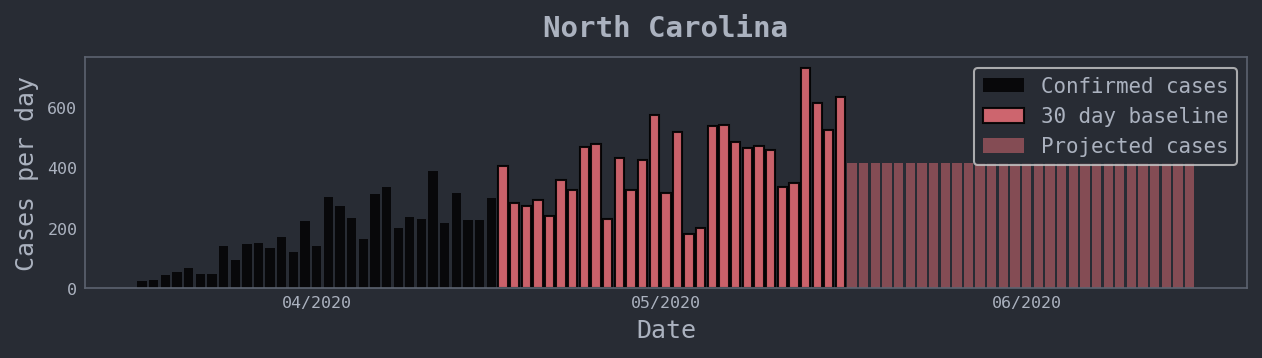

Ohio


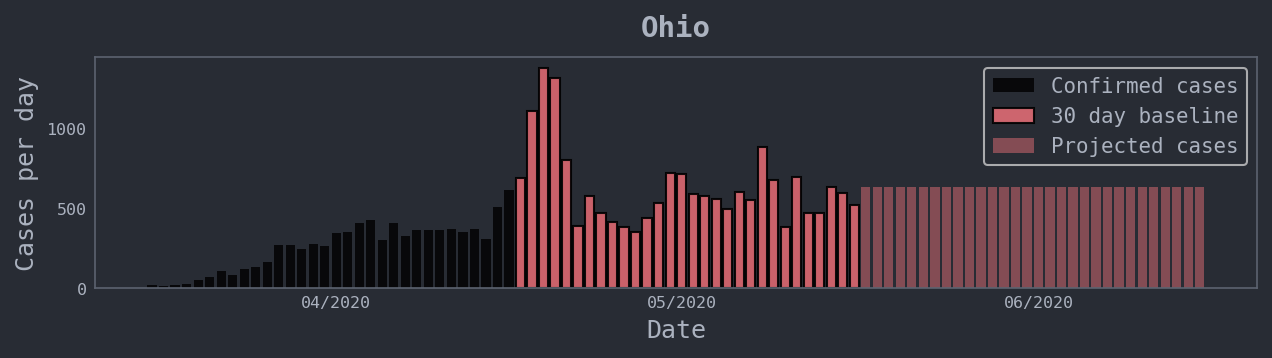

Oklahoma


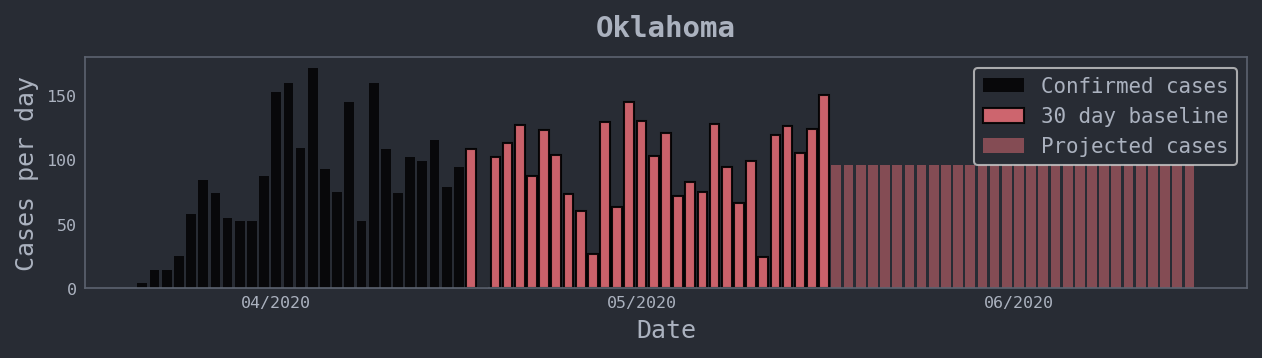

Oregon


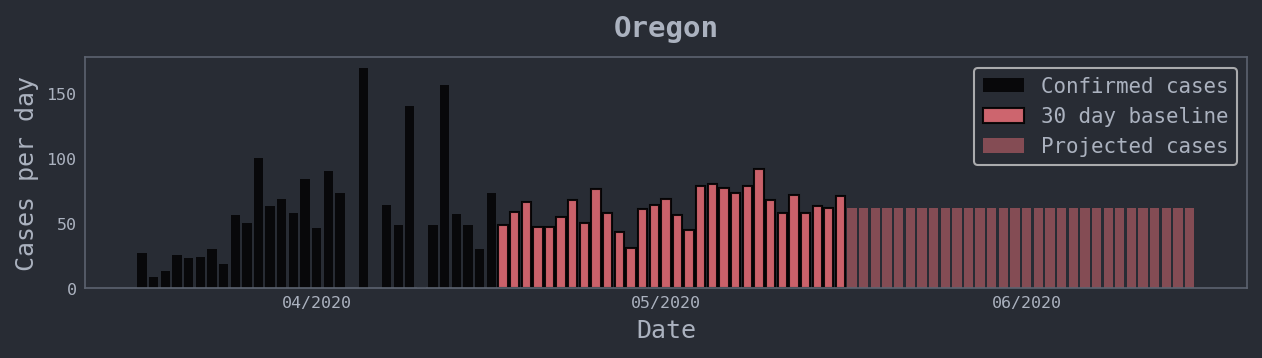

Pennsylvania


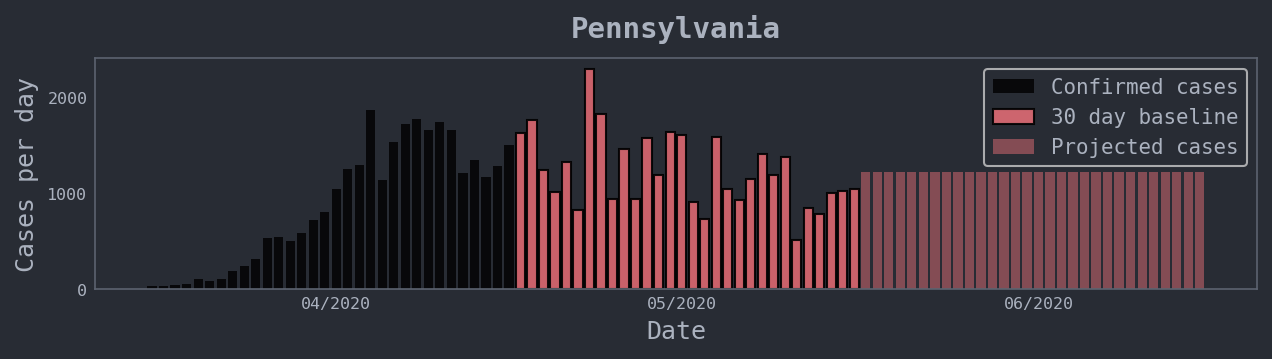

Rhode Island


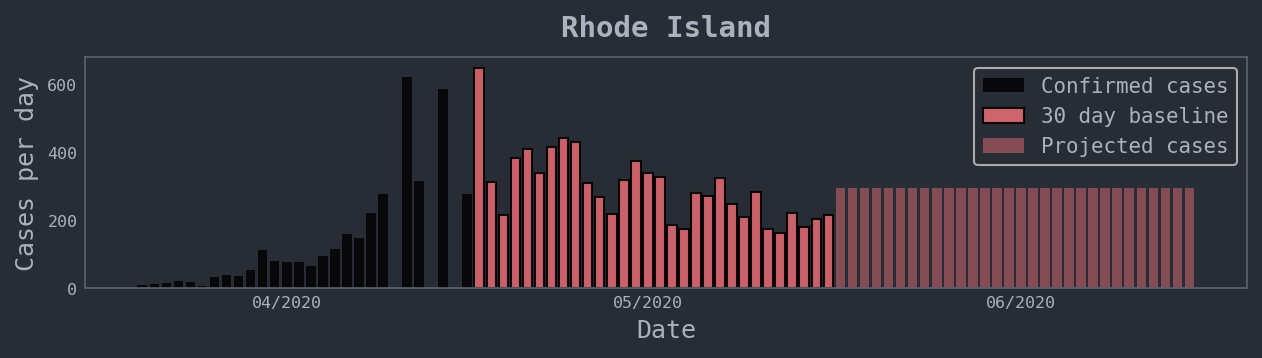

South Carolina


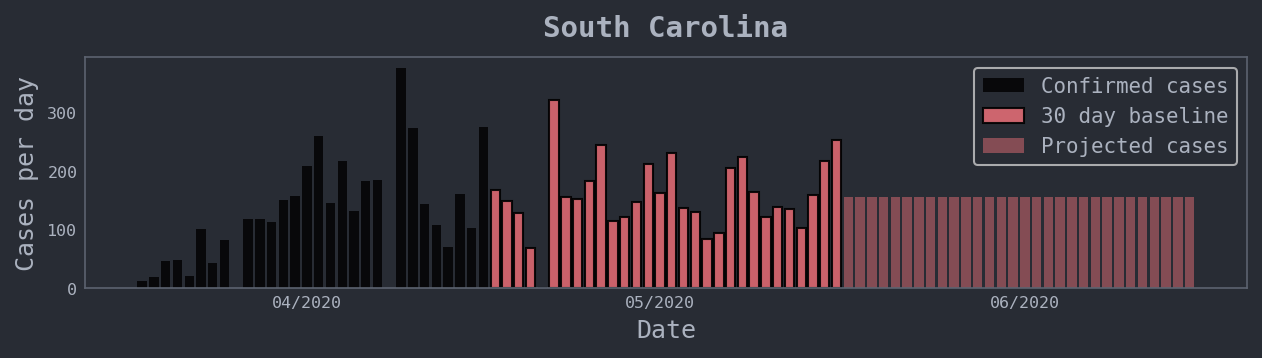

Tennessee


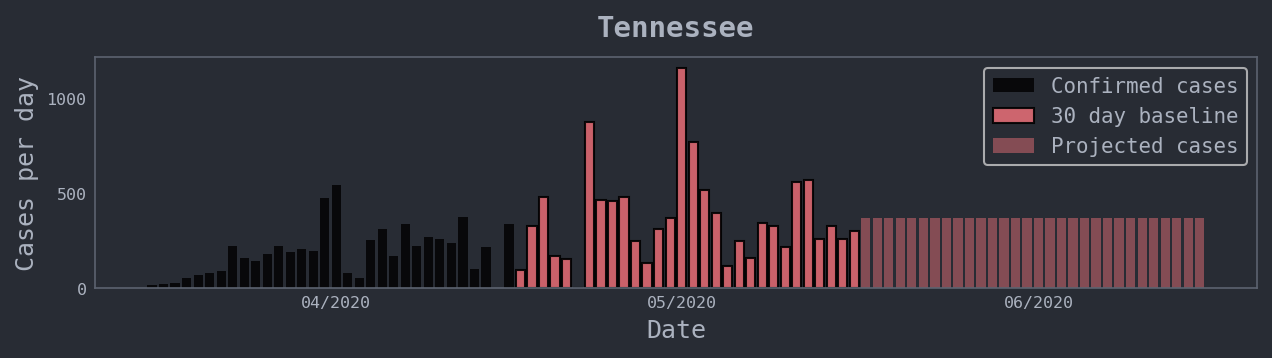

Texas


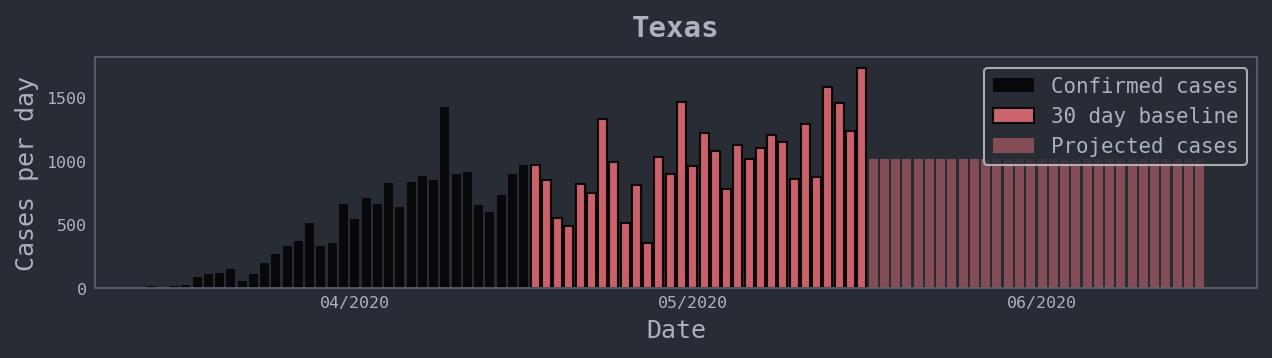

Virginia


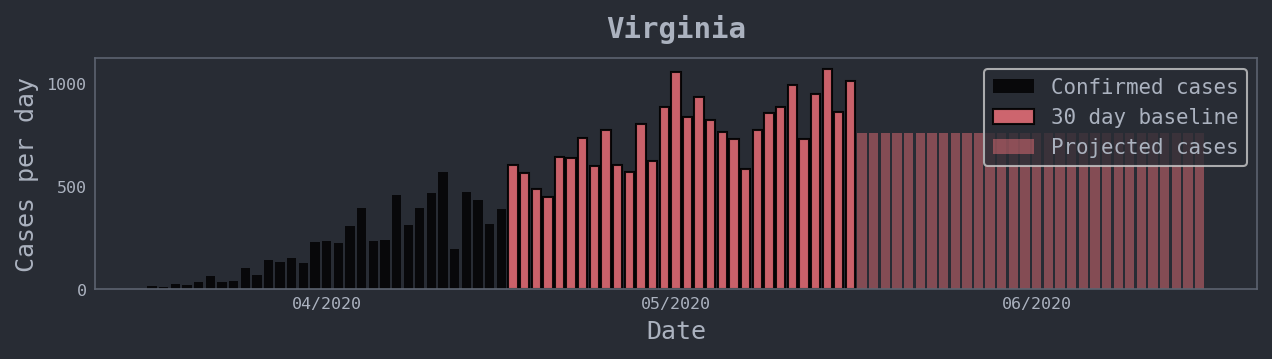

Washington


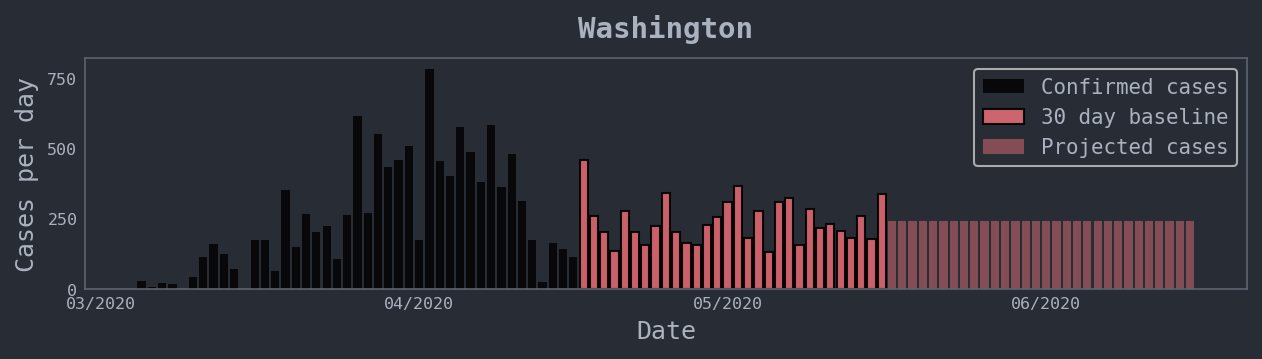

Wisconsin


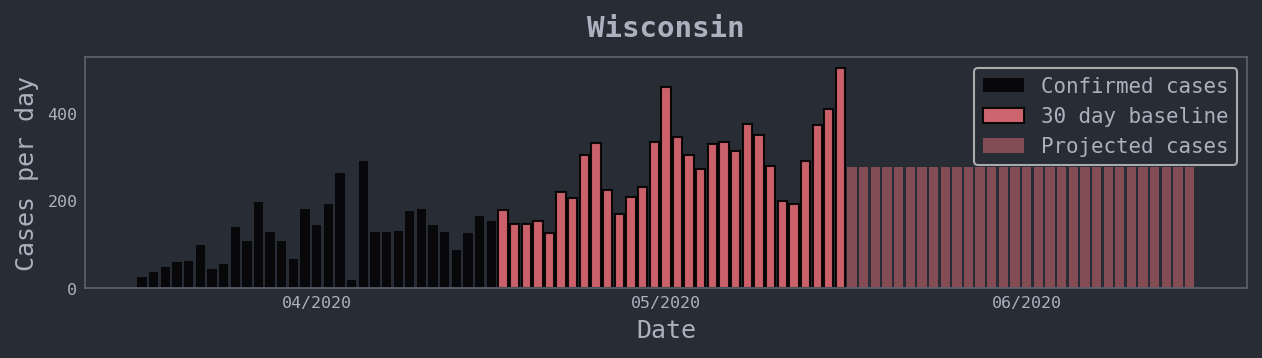

In [83]:

#hide_input
ignore = [] #['China', 'Switzerland']
for i, str_country in enumerate(countries):
    print(f'{str_country}')
    df_cases_country = dff2[dff2['state']==str_country]      

    fig, axs = plt.subplots(1, 1, figsize=(10, 2), dpi=150)
    axs.set_title(f'{str_country}', fontsize=14, fontweight='bold')
    
    axs.bar(df_cases_country.index, df_cases_country.new_confirmed, lw=4, label=f'Confirmed cases', color='k', alpha=0.8)
    
    fit_cases = df_cases_country.iloc[-MEAN_CASES_DAYS:]
    axs.bar(fit_cases.index, fit_cases.new_confirmed, lw=1, edgecolor='k', label=f'{MEAN_CASES_DAYS} day baseline', color='C0', alpha=0.9)
    
    
    axs.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every x months
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y')) 
    
    days_to_go = 30
    projected_cases_per_day = int(new_cases_mean_list[i])
    last_date = df_cases_country.iloc[[-1]].index + datetime.timedelta(days=1)
    future_cases = pd.DataFrame(index=pd.date_range(last_date[0], periods=int(days_to_go), freq='D'), columns=['new_confirmed'])
    future_cases['new_confirmed'] = projected_cases_per_day


    axs.bar(future_cases.index, future_cases.new_confirmed, lw=4, color='C0', label=f'Projected cases', alpha=0.5)


    axs.legend(loc=1, fontsize=10)

    plt.xlabel(f'Date', fontsize=12)
    axs.xaxis.set_tick_params(width=1)
    axs.yaxis.set_tick_params(width=1)
    plt.xticks(rotation=0, fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    axs.set_ylabel(f'Cases per day', fontsize=12)
    plt.show()